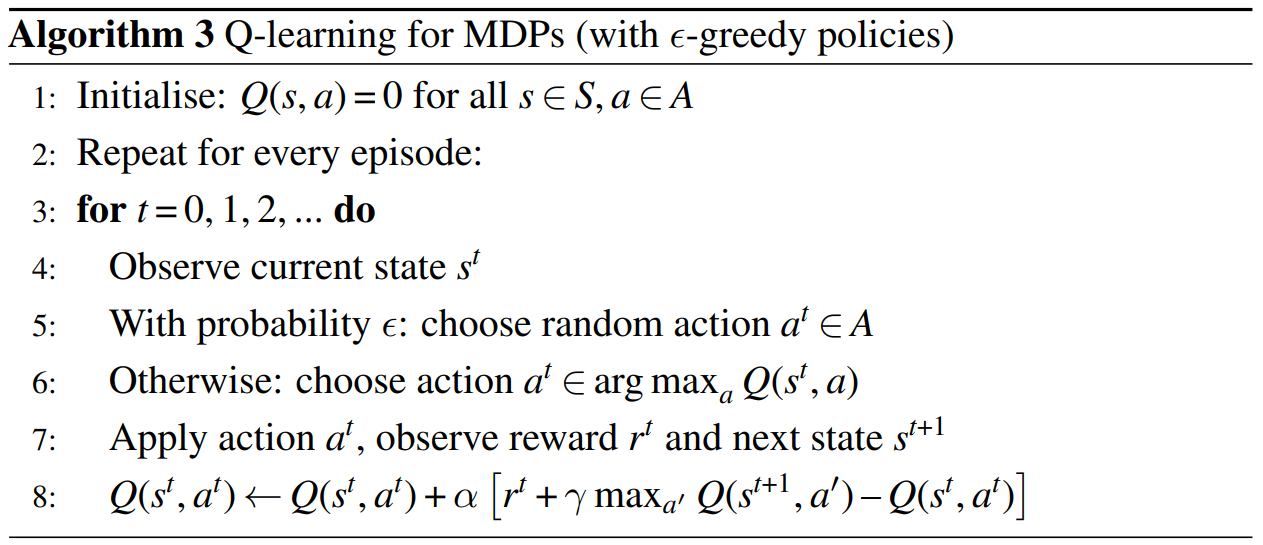

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import trange
from matplotlib import pyplot as plt
import seaborn as sns

from environment.mars_rover import MarsRover


sns.set_theme()
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["text.usetex"] = True

In [2]:
def random_Q_argmax(Q, state, rng):
    exploit_actions_idx = np.argwhere(Q[state] == Q[state].max())
    return rng.choice(exploit_actions_idx.flatten())


def sample_action(Q, state, epsilon, rng):
    exploit = rng.choice([True, False], p=[1 - epsilon, epsilon])
    if exploit:
        action = random_Q_argmax(Q, state, rng)
    else:
        action = rng.choice(range(Q.shape[1]))

    return action


def q_learning(
    make_env,
    alpha_function,
    epsilon_schedule,
    gamma=0.95,
    n_timesteps=500,
    n_evaluation_games=100,
    evaluation_interval=10,
    seed=666,
):
    env = make_env()
    rng = np.random.default_rng(seed)
    state_space_size = env.observation_space.n
    action_space_size = env.action_space.n
    Q = np.zeros((state_space_size, action_space_size))
    K = np.zeros((state_space_size, action_space_size))

    evaluations = []

    done = True
    for timestep in range(n_timesteps):
        if timestep % evaluation_interval == 0:
            eval_metric, episodes_lengths = evaluate(
                make_env=make_env,
                Q=Q,
                rng=rng,
                gamma=gamma,
                n_games=n_evaluation_games,
                seed=seed * timestep,
            )
            evaluations.append(
                {
                    "returns": eval_metric,
                    "lengths": episodes_lengths,
                    "timestep": timestep,
                }
            )

        if done:
            state, _ = env.reset(seed + timestep)

        epsilon = epsilon_schedule(timestep, n_timesteps)
        action = sample_action(Q, state, epsilon, rng)
        next_state, reward, done, *_ = env.step(action)
        K[state, action] += 1
        alpha = alpha_function(K[state, action])
        argmax_next_action = random_Q_argmax(Q, next_state, rng)
        Q[state, action] += alpha * (
            reward + gamma * Q[next_state, argmax_next_action] - Q[state, action]
        )
        state = next_state
    return Q, evaluations


def evaluate(make_env, Q, rng, gamma=0.95, n_games=100, seed=666):
    env = make_env()
    returns = []
    episodes_lengths = []

    for i in range(n_games):
        state, _ = env.reset(seed=seed + i)
        done = False
        rewards = []
        t = 0
        while not done:
            action = rng.choice(
                np.argwhere(Q[state] == Q[state].max()).flatten()
            )
            state, reward, done, *_ = env.step(action)
            rewards.append(gamma**t * reward)
            t += 1
        returns.append(sum(rewards))
        episodes_lengths.append(t)

    return np.mean(returns), np.mean(episodes_lengths)


def inverse_alpha_function(k):
    return 1 / k


def linear_epsilon_schedule(timestep, max_steps):
    return 1 - timestep / max_steps


n_timesteps = 500

Qs = []
metrics = []
for i in trange(100):
    Q_values, metric = q_learning(
        make_env=MarsRover,
        alpha_function=inverse_alpha_function,
        epsilon_schedule=linear_epsilon_schedule,
        gamma=0.95,
        n_timesteps=n_timesteps,
        n_evaluation_games=100,
        evaluation_interval=n_timesteps // 50,
        seed=666 * (i + 1),
    )
    Qs.append(Q_values)
    metrics.append(metric)
env = MarsRover()
df = pd.DataFrame(
    np.array(Qs).mean(axis=0),
    index=env.STATES.values(),
    columns=env.ACTIONS.values(),
)
df.loc[
    [not env.is_terminal(state) for state in range(env.observation_space.n)]
]

  0%|          | 0/100 [00:00<?, ?it/s]

,Left,Right
Start,3.440834,-0.139469
Site A,1.393140,6.002328
Site B,4.100632,10.000000


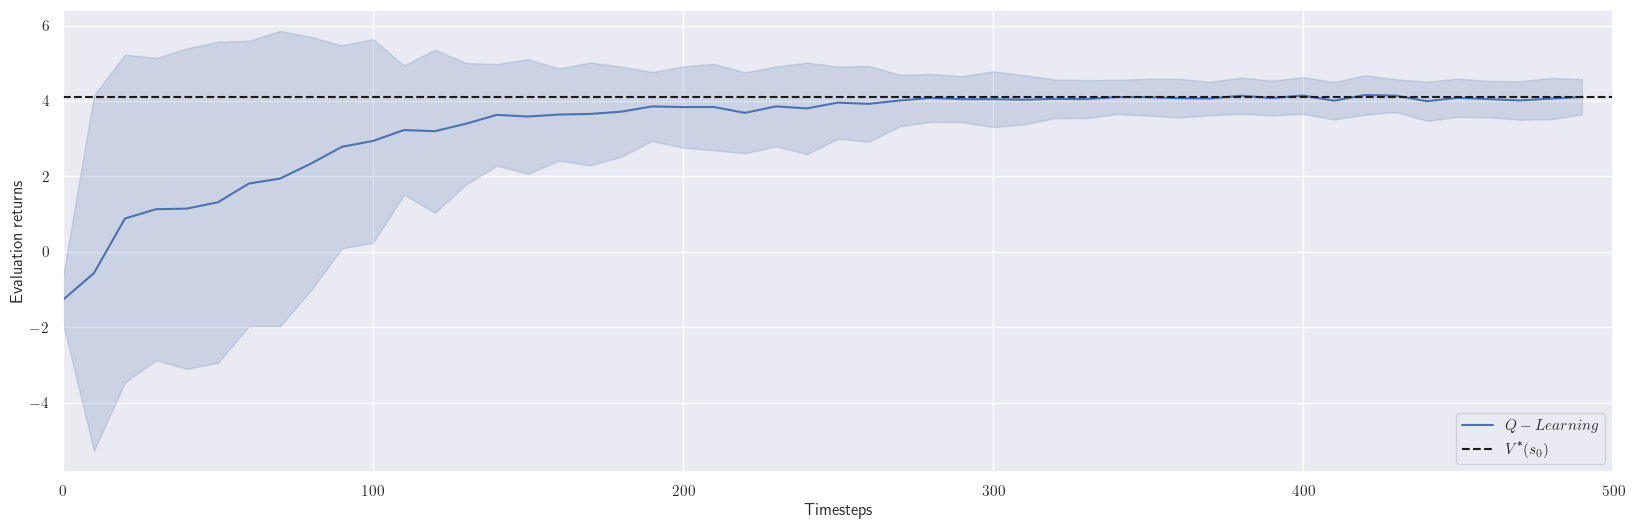

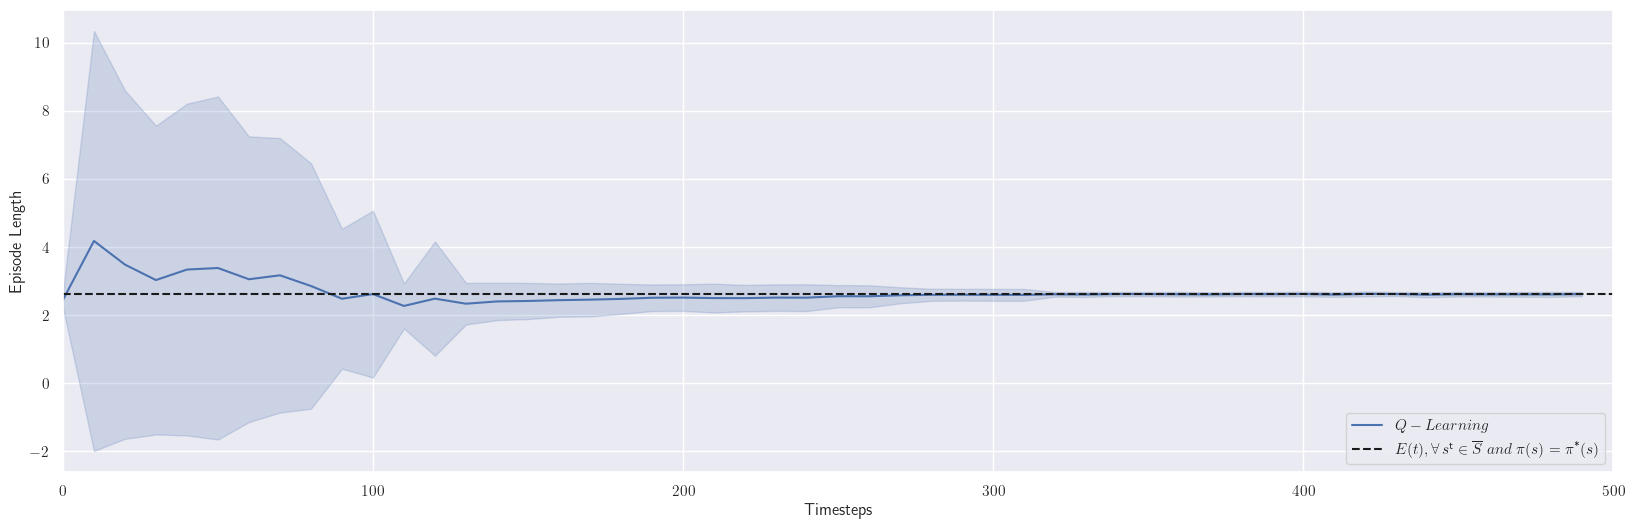

In [3]:
metrics_df = pd.DataFrame.from_dict(
    {k: v for k, v in enumerate(metrics)},
    orient="columns",
)
timesteps = [x["timestep"] for x in metrics_df.iloc[:, 0]]
metrics_df = metrics_df.map(lambda x: x["returns"])
metrics_df.insert(0, "timesteps", timesteps)
metrics_df = pd.melt(metrics_df, id_vars=["timesteps"], value_name="metric")
metrics_df = metrics_df.drop(columns="variable").sort_values("timesteps")

ax = sns.lineplot(
    data=metrics_df,
    x="timesteps",
    y="metric",
    errorbar="sd",
    label="$Q-Learning$",
)
ax.hlines(
    4.1,  # from value iteration
    xmin=0,
    xmax=n_timesteps,
    ls="--",
    color="k",
    label=r"$V\textsuperscript{*}(s_{0})$",
)
ax.set_xlim(0, n_timesteps)
plt.legend(loc="lower right")
plt.xlabel("Timesteps")
plt.ylabel("Evaluation returns")
plt.show()

metrics_df = pd.DataFrame.from_dict(
    {k: v for k, v in enumerate(metrics)},
    orient="columns",
)
timesteps = [x["timestep"] for x in metrics_df.iloc[:, 0]]
metrics_df = metrics_df.map(lambda x: x["lengths"])
metrics_df.insert(0, "timesteps", timesteps)
metrics_df = pd.melt(metrics_df, id_vars=["timesteps"], value_name="length")
metrics_df = metrics_df.drop(columns="variable").sort_values("timesteps")

ax = sns.lineplot(
    data=metrics_df,
    x="timesteps",
    y="length",
    errorbar="sd",
    label="$Q-Learning$",
)

ax.hlines(
    # from transition matrix + optimal policy from value iteration:
    #  0.1 * 1 + 0.9 * (0.2 * 2 + 0.8 * 3) = 2.62
    2.62,
    xmin=0,
    xmax=n_timesteps,
    ls="--",
    color="k",
    label=r"$E(t), \forall \, s\textsuperscript{t} \in \overline{S} \; and \; \pi(s) = \pi\textsuperscript{*}(s)$",
)

ax.set_xlim(0, n_timesteps)
plt.legend(loc="lower right")
plt.xlabel("Timesteps")
plt.ylabel("Episode Length")
plt.show()